In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reference: https://lifetimes.readthedocs.io/en/latest/Quickstart.html

# 1. Data

Read the SQL query results which in the format specified by ```lifetimes``` package. If you only have transaction data like me, you can also use ```summary_data_from_transaction_data function``` in ```lifetimes``` package to a frequency, recency and age dataset. It will give the same result as SQL query.

Note: please be careful about the defination of recency and frequency, especially recency which "is equal to the duration between a customer’s first purchase and their latest purchase." It is a bit counterintuitive to me. I also calculate recency, called recency_trandition, defined as the time between last purchase and the end of the period under study. I will use recency_trandition for clustering only. 

In [2]:
data = pd.read_csv('rfm_w_holdout_ecomm_oct_nov.csv', index_col='user_id')
data['recency_trandition'] = data['t'] - data['recency']

data

,recency,frequency,t,monetary,frequency_holdout,duration_holdout,recency_trandition
user_id,,,,,,,
264649825,0,0,25,0.000000,0,30,25
303160429,0,0,18,0.000000,0,30,18
340041246,11,3,28,238.333338,0,30,17
371877401,0,0,22,0.000000,0,30,22
384989212,0,0,13,0.000000,1,30,13
...,...,...,...,...,...,...,...
566270177,0,0,0,0.000000,0,30,0
566272569,0,0,0,0.000000,0,30,0
566274637,0,0,0,0.000000,0,30,0


In order to use ```plot_calibration_purchases_vs_holdout_purchases``` function in ```lifetimes```, we need to rename the columns

In [3]:
data_cal_holdout = pd.DataFrame(data.loc[:, ['frequency', 'recency', 't', 'frequency_holdout', 'duration_holdout']].values,
                                columns=['frequency_cal', 'recency_cal', 'T_cal', 'frequency_holdout', 'duration_holdout'],
                                index=data.index).astype(float)
data_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
264649825,0.0,0.0,25.0,0.0,30.0
303160429,0.0,0.0,18.0,0.0,30.0
340041246,3.0,11.0,28.0,0.0,30.0
371877401,0.0,0.0,22.0,0.0,30.0
384989212,0.0,0.0,13.0,1.0,30.0
...,...,...,...,...,...
566270177,0.0,0.0,0.0,0.0,30.0
566272569,0.0,0.0,0.0,0.0,30.0
566274637,0.0,0.0,0.0,0.0,30.0


# 2. Estimating number of transition using BG/NBD model

## 2.1. Fit BG/NBD based on frequency, recency, and age

In [12]:
from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter, BetaGeoBetaBinomFitter
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0)

bgf.fit(data_cal_holdout['frequency_cal'], data_cal_holdout['recency_cal'], data_cal_holdout['T_cal'])
bgf.summary


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.673301,0.013351,0.647134,0.699468
alpha,7.540591,0.097918,7.348672,7.732509
a,0.899079,0.013469,0.872679,0.925478
b,1.019043,0.028508,0.963168,1.074919


## 2.2. Performance on training set

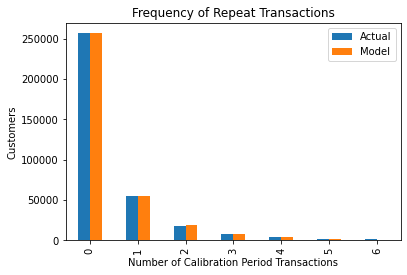

In [13]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)
plt.show()

## 2.3. Performance on test set

BG/NBD gives a reasonable acurate prediction on purchases numbers on the test set. For example, the users, who purchased 6 times in Oct, will purchase around 3 times in Nov. 

Note that the following plot only shows the average purchases numbers. If you look at the individual's purchases in frequency_holdout or model_predictions, you can see them actually varies a lot. Thus, the prediction on individual level won't be that accurate as indicated by the following plots.

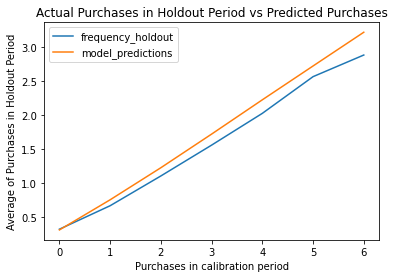

In [14]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(data_cal_holdout['frequency_cal'], data_cal_holdout['recency_cal'], data_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, data_cal_holdout)
plt.show()

## 2.4. Calculate conditional expected number of purchase for next month

In [142]:
t = 30 #predict purchases in 30 periods

predict_n_purchase = []
for n in range(len(data)):
    individual = data.iloc[n]
    p = bgf.predict(t, individual['frequency'], individual['recency'], individual['t'])
    predict_n_purchase.append(p)

In [143]:
data['n_purchase'] = predict_n_purchase

# 3. Estimating CLV using Gamma-Gamma model

## 3.1. The independence assumption

The Pearson correlation between monetary and frequency is sort of close to 0, thus we can use this model.

In [114]:
returning_customers_summary = data[data['frequency']>0]

In [116]:
returning_customers_summary[['monetary', 'frequency']].corr()

,monetary,frequency
monetary,1.000000,0.133312
frequency,0.133312,1.000000


## 3.2. calculate average profit (revenue in this case) per user

Expected conditional average profit: 482.5641922457281, Average profit: 431.35698359594625

In [117]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary'])

<lifetimes.GammaGammaFitter: fitted with 90604 subjects, p: 1.20, q: 2.02, v: 418.22>

In [121]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary']
    ).mean(),
    data[data['frequency']>0]['monetary'].mean()
))

Expected conditional average profit: 482.5641922457281, Average profit: 431.35698359594625


## 3.3. calculate CLV

In [147]:
bgf.fit(data['frequency'], data['recency'], data['t'])

pred_clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['t'],
    data['monetary'],
    time=6, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [152]:
pred_clv

user_id
264649825     269.542688
303160429     348.677281
340041246     683.298618
371877401     299.200655
384989212     434.544760
                ...     
566270177    1043.057147
566272569    1043.057147
566274637    1043.057147
566276996    1043.057147
566278294    1043.057147
Name: clv, Length: 347118, dtype: float64